In [592]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import string
import pycountry
import seaborn as sns
sns.set_style('ticks')

In [447]:
def melted_author_list(scopus_dataframe):
    author_list = []
    new_list = []
    melted_authors = []
    
    for i in scopus_dataframe['Authors']:
        com_replace = i.split('., ')
        author_list.append(com_replace)

    for i in author_list:
        new_i = i
        for j in i:
            if j.endswith('.'):
                new_i.remove(j)
            new_list.append(new_i)
            
    for lists in new_list:
        for author in lists:
            if author not in melted_authors:
                melted_authors.append(author)
    return melted_authors,new_list

def node_collect(names_of_authors,new_list):
    node_collector = {}
    counter = 0
    for author in names_of_authors:
        value = []
        for i in new_list:
            if author in i:
                for node_author in i:
                    if node_author not in value:
                        value.append(node_author)
        node_collector[author] = value
        counter += 1
        if not (counter%1000):
            print(f'{counter} authors processed')
    return(node_collector)

def edge_collect(nodes_dict):
    edge_collector = []
    for node_value,edges in nodes_dict.items():
        for actual_edge in edges:
            if actual_edge!=node_value:
                out = (node_value,actual_edge)
                edge_collector.append(out)   
    return edge_collector

def network_graph(nodes,edges):
    G = nx.Graph() 
    G.clear()
    for i in nodes.keys():
        G.add_node(i)
    G.add_edges_from(edges)
    print(f'nodes: {G.number_of_nodes()}\nedges: {G.number_of_edges()}')
    return G

def unique_author(data_used):
    new_list = []
    unique_author = []
    for i in data_used['Authors']:
        a = i.split(';')
        new_list.append(a)
    for author in (i for i in new_list):
        unique_author += author[0].split(', ')
    unique_author = set(unique_author)
    return unique_author

def source_summary(data_used):
    summary = {}
    summary['number of articles'] = data_used.shape[0]
    summary['total number of authors'] = len(unique_author(data_used))
    summary['average number of authors per article'] = len(unique_author(source)) / data_used.shape[0]
    summary['average number of citation per article'] = sum(source['Cited by'].fillna(0)) / data_used.shape[0]
    return summary

def author_frequency(data_used):
    ids = []
    freq = []
    for i in (j.split('., ') for j in data_used['Authors']):
        ids += i
    for i in set(ids):
        freq.append([i , ids.count(i)])
    freq = pd.DataFrame(freq)
    freq.columns = ['author', 'freq']
    return freq

def author_citation(data_used):
    new_list = []
    for i in data_used['Authors']:
        a = i.split('., ')
        new_list.append(a)
    freq = {}
    for auth, cited in zip(new_list,data_used['Cited by']):
        for i in auth:
            try:
                if freq[i] != 0:
                    freq[i] += freq[i]+cited
                else:
                    freq[i] = cited
            except: 
                freq[i] = 0
                if freq[i] != 0:
                    freq[i] += freq[i]+cited
                else:
                    freq[i] = cited
    freq = pd.DataFrame.from_dict(freq, orient = 'index').reset_index().fillna(0)
    freq.columns = ['author', 'cite']
    return freq

def country_affiliation(data_used):
    country = {}
    for i in list(pycountry.countries):
        country[i.name] = 0 
    country['NoAffiliation'] = 0
    punctuation = string.punctuation
    addresses = data_used['Correspondence Address'].fillna('NoAffiliation')
    for address in addresses:
        string_to_replace = ''
        for punc in punctuation:
            if len(string_to_replace) == 0:
                string_to_replace = address.replace(punc,"")
            else:
                string_to_replace = string_to_replace.replace(punc,"")
        string_to_replace = string_to_replace.split(' ')
        for i in list(pycountry.countries):
            if i.name in string_to_replace:
                country[i.name] += 1
    country_affil = pd.DataFrame.from_dict(country,orient = 'index').reset_index()
    country_affil.columns =  ['country','number of publications']
    return country_affil.sort_values(by = 'number of publications', ascending=False)



In [638]:
#path = 'path/to/csv'
#year = [start_year,end_year]
#threshold = top number of authors to create network plot 
#label = All Labels (default False)
#label_no = number of top nodes to be labels (default 10)
def run_network_analysis(data_used,year = [0,2020],threshold = 10, label = False, label_no = 10, plt_label = 'noLabelPassed'):
    labels = {}
    print ('increasing the delta of years exponentially increases computation load')
    #data_used = pd.read_csv(path)    
    data_used = data_used[data_used['Year'] < year[1]]
    data_used = data_used[data_used['Year'] > year[0]]
    print (f'{data_used.shape[0]}: Articles from year {year[0]} to {year[1]} identified')
    print (f'Threshold range: 0 - {data_used.shape[0]}\nrecommended range 20-50')
    melted_authors,new_list = melted_author_list(data_used)
    node_collector = node_collect(melted_authors,new_list)
    author_affil = {}
    for i in node_collector.keys():
        author_affil[i] = len(node_collector[i])
    author_affil = pd.DataFrame.from_dict(author_affil,orient = 'index').reset_index().rename(columns = {'index':'author',0:'affiliated_authors'}).sort_values(by='affiliated_authors',ascending=True)    
    selector = author_affil.sort_values(by='affiliated_authors',ascending=False).head(threshold)['author']
    selector_val = author_affil.sort_values(by='affiliated_authors',ascending=False).head(threshold)['affiliated_authors']
    nodes = node_collect(selector,new_list)
    edges = edge_collect(nodes)
    for label in author_affil.sort_values(by = 'affiliated_authors',ascending = False).head(label_no)['author']:
        labels[label] = label
    G = network_graph(nodes,edges)
    d = nx.degree(G)
    d = [(d[node]+1) * 20 for node in G.nodes()]
    plt.figure(figsize = (30,15))
    #plt.figtext(0,1, plt_label, fontsize=50,ha = 'right',weight = 'bold')
    nx.draw(G, node_size = [size for size in d],labels = labels)
    plt.suptitle(plt_label, fontsize=50, weight = 'bold',ha = 'left')
    plt.savefig(f'/Users/tim/Desktop/{plt_label}.pdf')
    return author_affil

# Summary output 
- Total number of publications
- Total number of authors
- The average number of authors per paper over the study period
- The average number of citations per paper
- Most productive authors (top ten) for each category  ( Total papers, Total citations, average citations per paper, h index)
- For each category the authors who established the most links with other authors
- The authors with highest value of betweenness centrality
- Top cited 4-5 papers under each category with number of citations.
- For all over the world data, for each category  publication share rank of top ten countries

# Information

In [641]:
disease = 'Sickle Cell Anemia Worldwide'
source = pd.read_csv('/Users/tim/Desktop/sca_worldwide_scopus.csv', error_bad_lines = False)
years = [1991 , 2014]

# Filetering Source according to years
source = source[source['Year'] < years[1]]
source = source[source['Year'] > years[0]]

b'Skipping line 12025: expected 19 fields, saw 20\n'


In [599]:
def analysis(source,year = [0,2020],plt_label = 'No title passed',contry_analysis = False):
    source = source[source['Year'] <= year[1]]
    source = source[source['Year'] >= year[0]]
    summary = source_summary(source)
    cite = author_citation(source)
    freq = author_frequency(source)
    final = cite.merge(freq, on = 'author').sort_values(by = 'cite',ascending = False)
    final = final.merge(affil, on = 'author')
    if contry_analysis == True:
        country_affil = country_affiliation(source)
        a = country_affil[country_affil['number of publications']!=0].set_index('country').plot(kind = 'bar',title = plt_label)    
        return final, country_affil, a
    else:
        return final

increasing the delta of years exponentially increases computation load
5650: Articles from year 1991 to 2014 identified
Threshold range: 0 - 5650
recommended range 20-50
1000 authors processed
2000 authors processed
3000 authors processed
4000 authors processed
5000 authors processed
6000 authors processed
7000 authors processed
8000 authors processed
9000 authors processed
10000 authors processed
11000 authors processed
12000 authors processed
13000 authors processed
nodes: 1479
edges: 3123


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


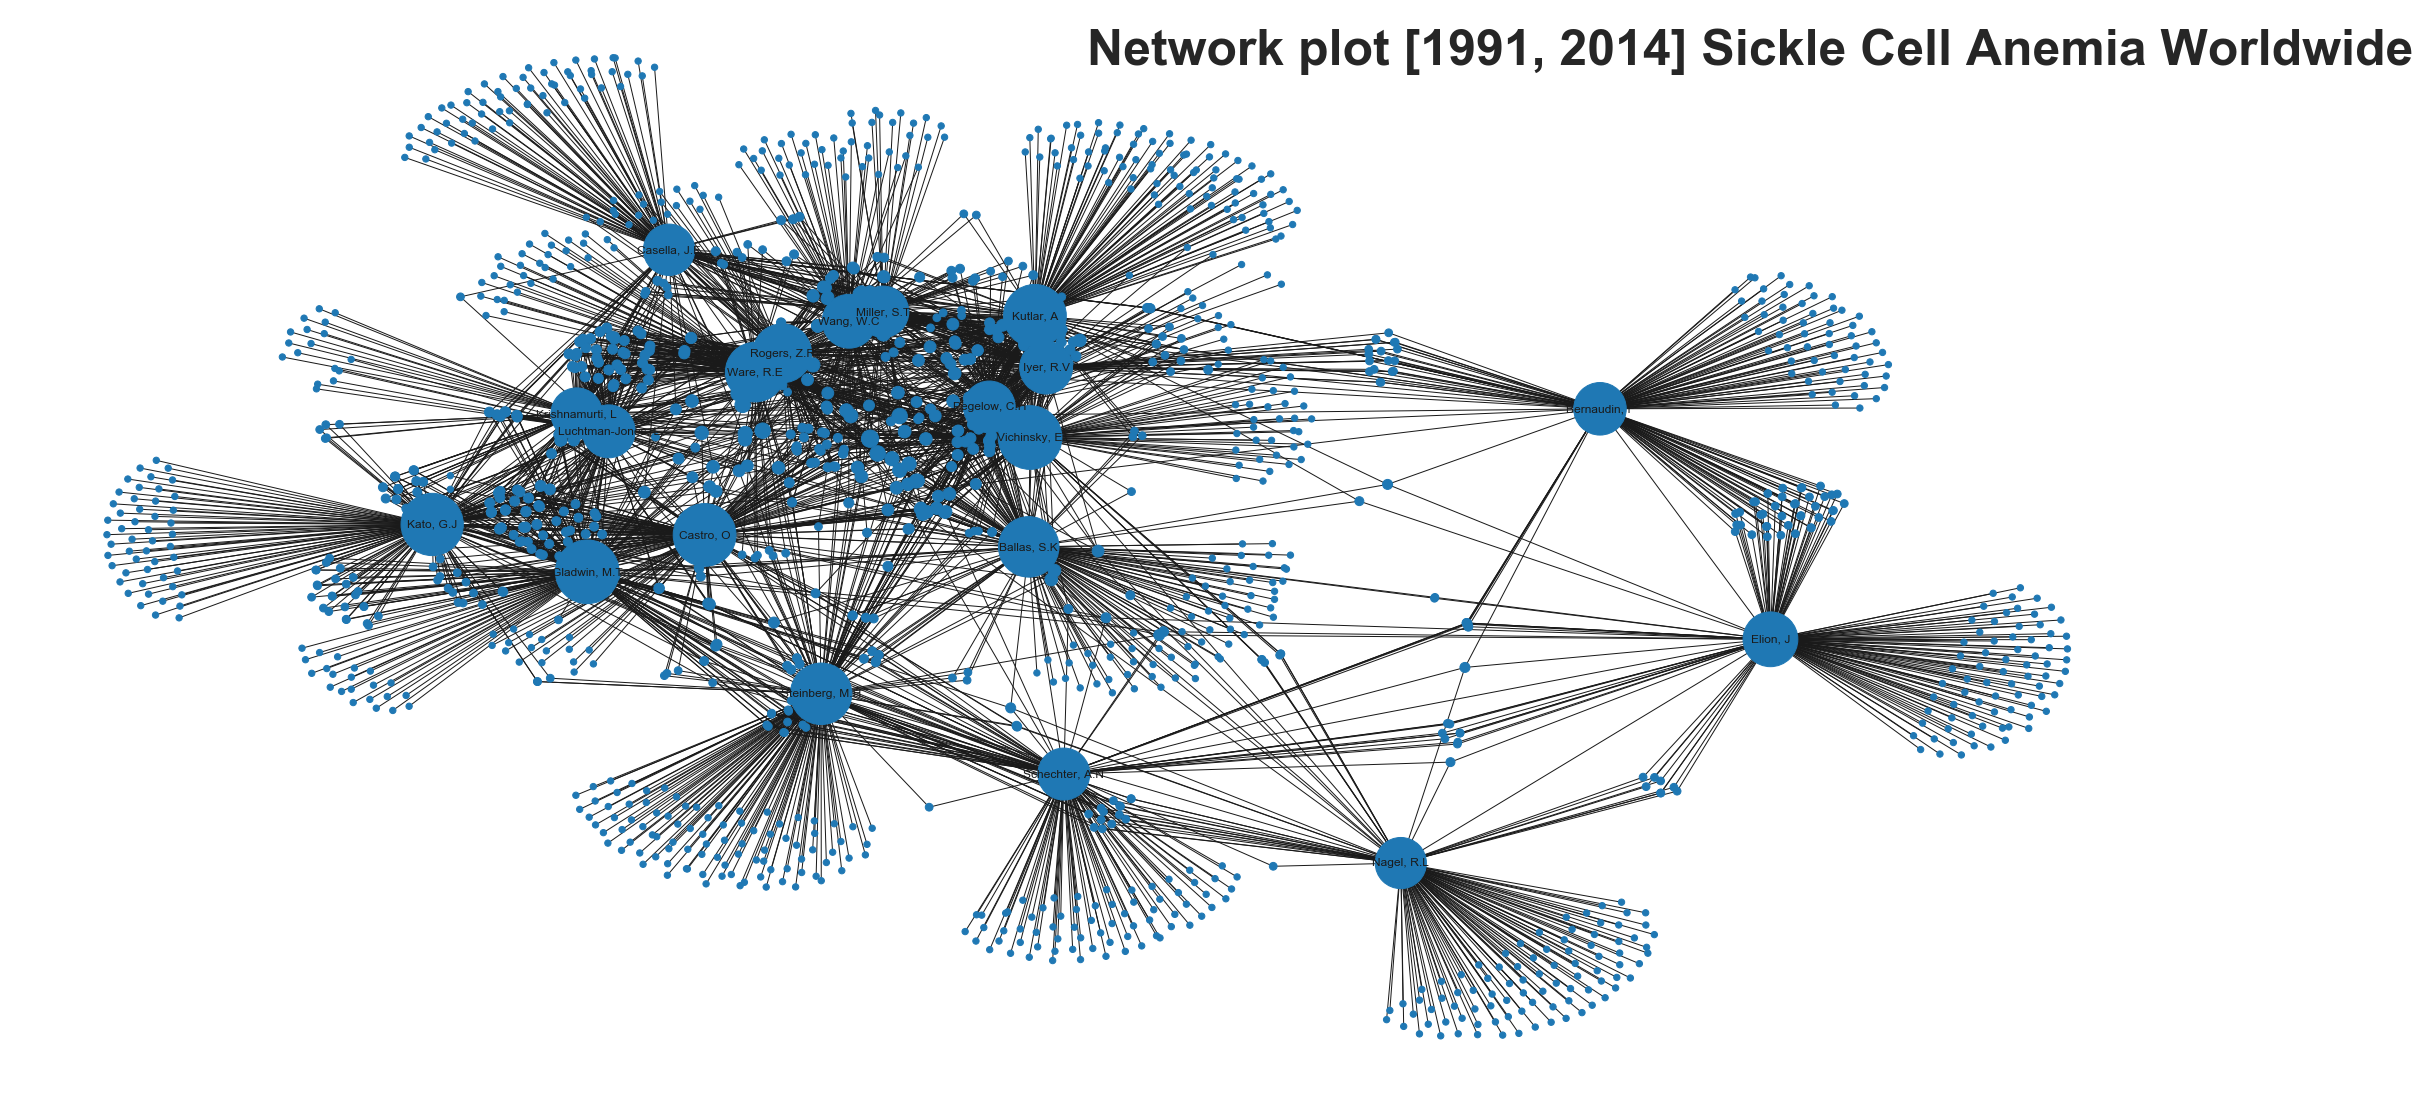

In [668]:
plt_label = f'Network plot {years} {disease}'
affil = run_network_analysis(source,year = years , threshold = 20, label_no = 20, label = False, plt_label = plt_label)

In [435]:
#final, country_affil, a = analysis(source,plt_label,country_analysis = True)
final = analysis(source,year = years,plt_label = plt_label)

In [437]:
final.head(50)

,author,cite,freq,affiliated_authors
0,"Gladwin, M.T",2.412973e+17,53,222
1,"Schechter, A.N",1.007801e+12,34,135
2,"Ware, R.E",3.647119e+11,31,205
3,"Wang, W.C",8.741793e+10,33,158
4,"Kutlar, A",3.324036e+10,30,202
5,"Connes, P",5.093451e+09,27,85
6,"Etienne-Julan, M",3.731766e+09,28,66
7,"Noguchi, C.T",1.007859e+09,24,90
8,"Bachir, D",8.963580e+08,26,95
9,"Vichinsky, E",8.246893e+08,23,203


In [409]:
country_affil[country_affil['number of publications']!=0]

,country,number of publications
104,India,11
80,Georgia,2


In [448]:
source_summary(source)

{'number of articles': 6122,
 'total number of authors': 14307,
 'average number of authors per article': 2.3369813786344333,
 'average number of citation per article': 29.934008493956224}

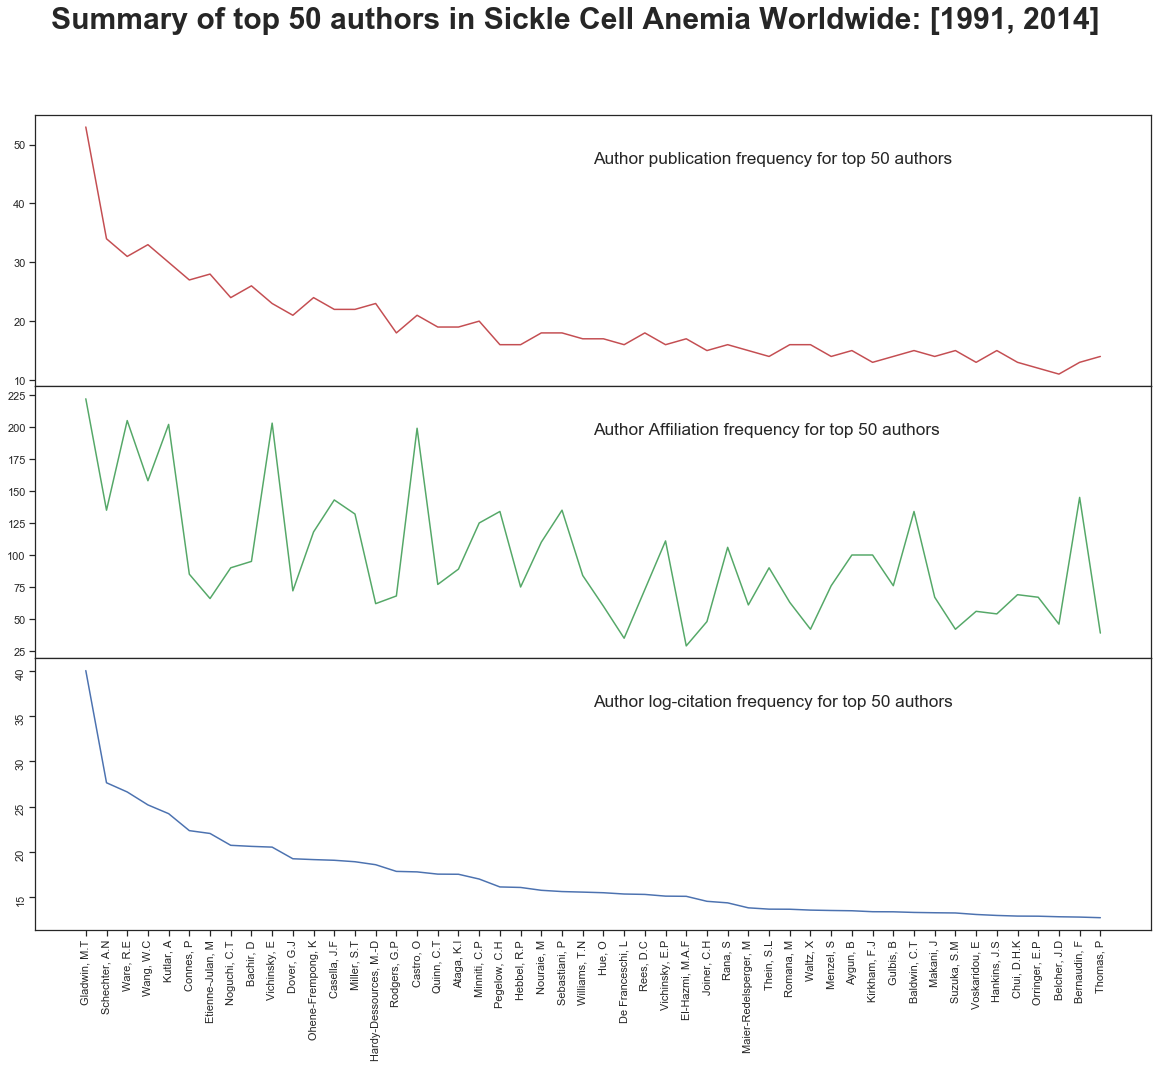

In [692]:
#log normal citations 
cite = []
for i in final['cite']:
    if i > 0:
        cite.append(math.log(i))
    else:
        cite.append(0)
        
#subplots for final analysis    

f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize = (20,15))
ax1.set_title('Author publication frequency for top 50 authors',size = 'xx-large',y=0.8,ha='left')
ax1.plot(final[['author','freq']].set_index('author').head(50),color = 'r')
ax1.set_xticks([])

ax2.set_title('Author Affiliation frequency for top 50 authors', size = 'xx-large',y=0.8,ha='left')
ax2.plot(final[['author','affiliated_authors']].set_index('author').head(50),color = 'g')
ax2.set_xticks([])

ax3.set_title('Author log-citation frequency for top 50 authors', size = 'xx-large',y=0.8,ha='left')
ax3.plot(final[['author','cite']].set_index('author').head(50))
ax3.tick_params(labelrotation = 90)
f.subplots_adjust(hspace = 0)
f.suptitle(f'Summary of top 50 authors in {disease}: {years}', fontsize=30, weight = 'bold')
f.savefig(f'/Users/tim/Desktop/{disease}_summary.pdf')


In [498]:
summary

{'number of articles': 17,
 'total number of authors': 71,
 'average number of authors per article': 8.870588235294118,
 'average number of citation per article': 16.705882352941178}

In [489]:
final ['cite'] = cite

In [535]:
pub_freq = []
for i in source['Source title'].fillna('NoJournal').unique():
    pub_freq.append([i , list(source['Source title'].fillna('NoJournal')).count(i)])
pub_freq = pd.DataFrame(pub_freq).sort_values(by = 1)

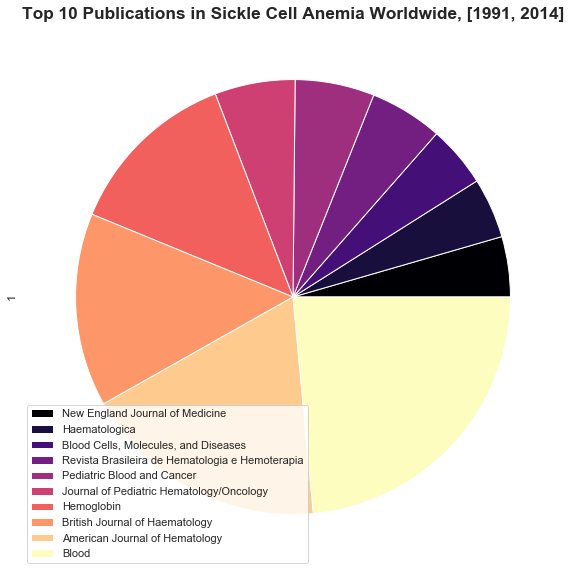

In [707]:
pub_freq.set_index(0).tail(10).plot(kind = 'pie',subplots = True,labeldistance = None ,legend = True,figsize = (10,10),cmap = 'magma')
plt.title(f'Top 10 Publications in {disease}, {years}',size = 'xx-large',weight = 'bold')
plt.savefig(f'/Users/tim/Desktop/{disease}_top_countries.pdf', dpi = 300, transparent = True, quality = 100,orientation = 'landscape')